# 딥러닝 사용해보기

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings 
warnings.filterwarnings('ignore')
import os 
import re
import FinanceDataReader as fdr
import joblib

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score ,accuracy_score, precision_score, recall_score, confusion_matrix
import joblib 

rfc = RandomForestClassifier()
xgb = XGBClassifier()
cat = CatBoostClassifier()
models = [rfc,xgb,cat]

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf

In [39]:
df_kospi = pd.read_csv('./data/recent_kospi_list.csv',index_col=0)
# 코드 반환
def corp_code(corp_name):
    code = df_kospi[df_kospi['Name']==corp_name]['Symbol'].iloc[0]
    code = str(code).zfill(6)
    return code

In [40]:
# 주가데이터
def stock_price(code,bgn_date= '2016-01-01',end_date= '2022-03-31'):

    df_p = fdr.DataReader(code,bgn_date,end_date)
    df_p = df_p.reset_index()
    df_p = df_p.rename(columns = {'Date': '날짜'})
    df_p = df_p.set_index('날짜',drop=True)
    
    return df_p

In [41]:
from sklearn.preprocessing import MinMaxScaler

def mscaler(df):

    df.index = pd.DatetimeIndex(df.index)
    col_list = df.columns
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[col_list] = scaler.fit_transform(df[col_list])
    
    return df_scaled

In [42]:
# merge
def merge(df_count, df_scaled):
    df_merge = pd.merge(df_count,df_p_scaled['Close_scaled'],left_index=True,right_index=True, how='right')
    df_merge = pd.merge(df_merge,df_p['Close'],left_index=True,right_index=True, how='right')
    return df_merge


In [43]:
def add_target(df_merge,window_size, period_rate):

    earning_lst = []
    for i in range(len(df_merge)-window_size):
        
        earning_rate = (df_merge.iloc[i+window_size,-1]- df_merge.iloc[i,-1])/df_merge.iloc[i,-1]

        if earning_rate >= period_rate:
            earning_lst.append(1)
        else:
            earning_lst.append(0)

    df_model = df_merge.iloc[:-window_size,:]
    df_model['target'] = earning_lst
    
    return df_model

In [44]:
def lstm_xy(df_merge,window_size, target_size, period_rate):
    
    X=[]
    Y=[]
    for i in range(len(df_merge) -window_size- target_size):
        # Feature
        X.append([df_merge.iloc[i+j,:-1] for j in range(window_size)])
                 
        # i+window_size일 이후 target_size 이후의 수익률
        earning_rate = (df_merge.iloc[i+window_size,-1]- df_merge.iloc[i+window_size+target_size,-1])/df_merge.iloc[i+window_size,-1]
        
        if earning_rate >= period_rate:
            Y.append(1)
        else:
            Y.append(0)
                 
    X = np.array(X).astype(float)
    Y = np.array(Y).astype(float)
        
    return X,Y

In [45]:
def get_clf_eval(y_test, pred, proba):
#     confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    try:
        roc_auc = roc_auc_score(y_test, proba)
    except:
        roc_auc = 0

    print('accuracy:{0:.4f}, precision:{1:.4f}, recall:{2:.4f}, roc_auc:{3:.4f}'.format(accuracy,precision,recall,roc_auc))

In [46]:
def feature20(model):

    # 배열형태로 반환
    ft_importance_values = model.feature_importances_

    # 정렬과 시각화를 쉽게 하기 위해 series 전환
    ft_series = pd.Series(ft_importance_values, index = x_train.columns)
    ft_top20 = ft_series.sort_values(ascending=False)[:20]

    # 시각화
    plt.figure(figsize=(8,6))
    plt.title('Feature Importance Top 20')
    sns.barplot(x=ft_top20, y=ft_top20.index)
    plt.show()

# 딥러닝(LSTM) 사용하기

In [26]:
path = './data/데이터_뉴스키워드빈도/'

corp_name = 'TCC스틸'
code = corp_code(corp_name)
df_p = stock_price(code)
df_p_scaled = mscaler(df_p)
df_p_scaled.rename(columns = {'Close':'Close_scaled'},inplace=True)

file_path = os.path.join(path,corp_name+'.csv')
df_count = pd.read_csv(file_path,index_col=0)
df_count.index = pd.DatetimeIndex(df_count.index)
df_count
df_count = mscaler(df_count)
df_merge = merge(df_count,df_p_scaled)
df_merge


,시세보,일오늘의증시,변화,현저한,처분,주가종목,형성,최고치,자기주식,지분변동,...,경신,철강,스틸주가,형지엘리트,신송홀딩스,상승,코스피,스틸,Close_scaled,Close
날짜,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082275,2041
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081433,2031
2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078237,1993
2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.074619,1950
2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072180,1921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.793892,10500
2022-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.827543,10900
2022-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.819130,10800


In [27]:
X,Y =lstm_xy(df_merge,60,30,0.1)

In [28]:
X[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08227475],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0814335 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07823673],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08420964],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07865736],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.08261126]])

In [29]:
X.shape

(1444, 60, 42)

In [16]:
Y.shape

(1444,)

In [30]:
train_test_split = 1100

x_train = X[:1100]
y_train = Y[:1100]

x_test = X[1100:]
y_test = Y[1100:]

In [31]:
with tf.device('/GPU:0'):
    model= Sequential()
    model.add(LSTM(50,input_shape=(60,42),activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                18600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 18,651
Trainable params: 18,651
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer='adam')

In [33]:
history = model.fit(x_train,y_train,epochs=30,batch_size=10, validation_data=(x_test,y_test))

Epoch 1/30
110/110 [==============================] - 8s 72ms/step - loss: 1.5753 - accuracy: 0.8673 - val_loss: 6669.1201 - val_accuracy: 0.8198
Epoch 2/30
110/110 [==============================] - 8s 69ms/step - loss: 0.4431 - accuracy: 0.8927 - val_loss: 108094.6406 - val_accuracy: 0.8198
Epoch 3/30
110/110 [==============================] - 8s 72ms/step - loss: 0.4113 - accuracy: 0.8936 - val_loss: 118436.0000 - val_accuracy: 0.8198
Epoch 4/30
110/110 [==============================] - 8s 71ms/step - loss: 0.3852 - accuracy: 0.8945 - val_loss: 255488.4375 - val_accuracy: 0.8198
Epoch 5/30
110/110 [==============================] - 8s 74ms/step - loss: 0.3649 - accuracy: 0.8945 - val_loss: 277001.7812 - val_accuracy: 0.8198
Epoch 6/30
110/110 [==============================] - 8s 74ms/step - loss: 3.0723 - accuracy: 0.8855 - val_loss: 0.5178 - val_accuracy: 0.8198
Epoch 7/30
110/110 [==============================] - 8s 72ms/step - loss: 8.3525 - accuracy: 0.8855 - val_loss: 14.650

In [48]:
observ_size= 60
window_size = 30
period_rate= 0.1

path = './data/데이터_뉴스키워드빈도/'
file_list = os.listdir(path)

for file in file_list[:] :
    corp_name = file[:-4]
    print('회사이름: ',corp_name)
    code = corp_code(corp_name)
    df_p = stock_price(code)
    df_p_scaled = mscaler(df_p)
    df_p_scaled.rename(columns = {'Close':'Close_scaled'},inplace=True)
    
    file_path = os.path.join(path,file)
    df_count = pd.read_csv(file_path,index_col=0)
    df_count.index = pd.DatetimeIndex(df_count.index)
    
    # 5개 미만 단어 아예없는경우는 생략
    try:
        df_count = mscaler(df_count)

        df_merge = merge(df_count,df_p_scaled)

        df_model = add_target(df_merge,window_size=window_size, period_rate= period_rate)

        x_train = df_model.loc[:'2021-10-01',:'Close_scaled']
        y_train = df_model.loc[:'2021-10-01','target']

        x_test = df_model.loc['2021-10-01':,:'Close_scaled']
        y_test = df_model.loc['2021-10-01':,'target']

        for model in models :
            model_name = model.__class__.__name__

            if model_name == 'CatBoostClassifier':
                model.fit(x_train,y_train, silent=True)
            else:
                model.fit(x_train,y_train)

            pred = model.predict(x_test)
            proba = model.predict_proba(x_test)[:,1]
            precision = precision_score(y_test, pred)
            recall = recall_score(y_test, pred)

            if (precision > 0.6) & (recall > 0.4) & (precision!=1):

                print('회사이름: ',corp_name)
                print('모델이름: ',model_name)
                save_path = f'./data/machine_model_30일_10/{corp_name}_{model_name}.pkl'
                joblib.dump(model, save_path)
                get_clf_eval(y_test,pred, proba)
                print(save_path)
                print('-'*50)
    except:
        print('출현 단어 5개 미만 종목')
        
    print('='* 50)

회사이름:  AJ네트웍스
[14:18:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
회사이름:  AK홀딩스
[14:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
출현 단어 5개 미만 종목
회사이름:  BGF
[14:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

회사이름:  BYC
[14:18:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
회사이름:  CJ CGV
[14:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
출현 단어 5개 미만 종목
회사이름:  CJ


KeyboardInterrupt: 

# 머신러닝 모델 불러오기

              precision    recall  f1-score   support

           0       0.85      0.97      0.90        68
           1       0.86      0.50      0.63        24

    accuracy                           0.85        92
   macro avg       0.85      0.74      0.77        92
weighted avg       0.85      0.85      0.83        92



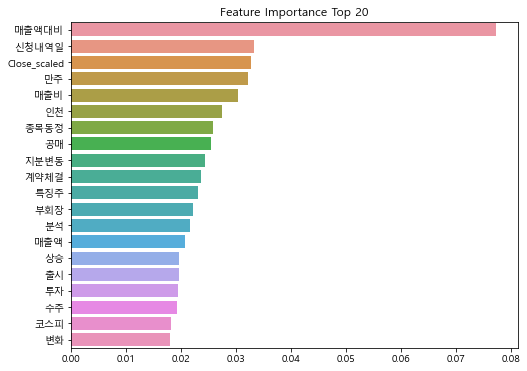

In [52]:
corp_name = '한미반도체'
window_size = 30
period_rate = 0.1

code = corp_code(corp_name)
df_p = stock_price(code)
df_p_scaled = mscaler(df_p)
df_p_scaled.rename(columns = {'Close':'Close_scaled'},inplace=True)

path = './data/데이터_뉴스키워드빈도/'
file_path = os.path.join(path,corp_name+'.csv')
df_count = pd.read_csv(file_path,index_col=0)
df_count.index = pd.DatetimeIndex(df_count.index)

df_merge = merge(df_count,df_p_scaled)

df_model = add_target(df_merge,window_size=window_size, period_rate= period_rate)

x_train = df_model.loc[:'2021-10-01',:'Close_scaled']
y_train = df_model.loc[:'2021-10-01','target']

x_test = df_model.loc['2021-10-01':,:'Close_scaled']
y_test = df_model.loc['2021-10-01':,'target']

# featurn importance
model_name = './data/machine_model_30일_10/한미반도체_XGBClassifier.pkl'
model = joblib.load(model_name)
pred = model.predict(x_test)

print(classification_report(y_test,pred))

# 시각화
ft_importance_values = model.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = x_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [69]:
word_list = ft_top20.index.tolist()
word_list.remove('Close_scaled')
word_list.extend(['Close_scaled','Close'])
word_list

['매출액대비',
 '신청내역일',
 '만주',
 '매출비',
 '인천',
 '종목동정',
 '공매',
 '지분변동',
 '계약체결',
 '특징주',
 '부회장',
 '분석',
 '매출액',
 '상승',
 '출시',
 '투자',
 '수주',
 '코스피',
 '변화',
 'Close_scaled',
 'Close']

## 선출된 단어만 사용해보기

In [70]:
path = './data/데이터_뉴스키워드빈도/'

corp_name = '한미반도체'
code = corp_code(corp_name)
df_p = stock_price(code)
df_p_scaled = mscaler(df_p)
df_p_scaled.rename(columns = {'Close':'Close_scaled'},inplace=True)

file_path = os.path.join(path,corp_name+'.csv')
df_count = pd.read_csv(file_path,index_col=0)
df_count.index = pd.DatetimeIndex(df_count.index)
df_count
df_count = mscaler(df_count)
df_merge = merge(df_count,df_p_scaled)

df_merge = df_merge[word_list]
df_merge


,매출액대비,신청내역일,만주,매출비,인천,종목동정,공매,지분변동,계약체결,특징주,...,분석,매출액,상승,출시,투자,수주,코스피,변화,Close_scaled,Close
날짜,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006745,2480
2016-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005621,2460
2016-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011804,2570
2016-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004497,2440
2016-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005621,2460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.832771,17175
2022-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.835582,17225
2022-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.855256,17575


In [71]:
X,Y =lstm_xy(df_merge,60,30,0.1)

In [80]:
X.shape

(1444, 60, 20)

In [81]:
train_test_split = 1100

x_train = X[:1100]
y_train = Y[:1100]

x_test = X[1100:]
y_test = Y[1100:]

In [82]:
with tf.device('/GPU:0'):
    model= Sequential()
    model.add(LSTM(50,input_shape=(60,20),activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                14200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


In [83]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [84]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'], optimizer=Adam)

In [85]:
history = model.fit(x_train,y_train,epochs=30,batch_size=10, validation_data=(x_test,y_test))

Epoch 1/30
110/110 [==============================] - 8s 71ms/step - loss: 0.6857 - accuracy: 0.7127 - val_loss: 0.6391 - val_accuracy: 0.8866
Epoch 2/30
110/110 [==============================] - 7s 61ms/step - loss: 0.6218 - accuracy: 0.7718 - val_loss: 54.8573 - val_accuracy: 0.8866
Epoch 3/30
110/110 [==============================] - 8s 72ms/step - loss: 0.5527 - accuracy: 0.7718 - val_loss: 3.0172 - val_accuracy: 0.8866
Epoch 4/30
110/110 [==============================] - 8s 72ms/step - loss: 0.5381 - accuracy: 0.7718 - val_loss: 0.4367 - val_accuracy: 0.8866 3s - loss: 0.5530 - accuracy: 0.76 - ETA: 3s - ETA:  - ETA: 1s -
Epoch 5/30
110/110 [==============================] - 8s 72ms/step - loss: 0.5245 - accuracy: 0.7718 - val_loss: 0.3725 - val_accuracy: 0.8866- loss: - ETA: 1s - los - ETA: 0s - loss:
Epoch 6/30
110/110 [==============================] - 8s 72ms/step - loss: 0.5076 - accuracy: 0.7718 - val_loss: 0.4084 - val_accuracy: 0.8866
Epoch 7/30
110/110 [===============

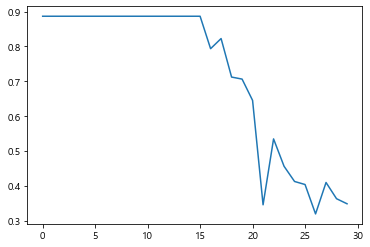

In [92]:
plt.plot(history.history['val_accuracy'])

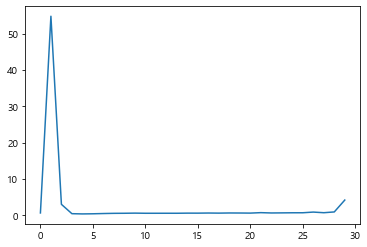

In [90]:
plt.plot(history.history['val_loss'])